# Python Assignment 5 Pragmatic Section
Team B

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import sounddevice as sd
import librosa
import librosa.display
import math
import scipy
import time
from scipy import signal
import os
import pandas as pd
import random
from scipy.io.wavfile import write

In [2]:
# Add classes for file information, instrument filters, and pure data integration
class FileClass:
    def __init__(self, sig, inst):
        self.signal = sig
        self.instrument = inst
        
class InstrumentFilters:
    def __init__(self):
        self.firTaps = random.randrange(100)
        # fc = random float from 0 to 1
        self.fc = random.random()
        # chose filter 0 to 6 in pure data
        self.iirFilter = random.randrange(6)
        
#class PureDataIIR:
#    def __init__(self, fileName, instrument):
#        iirFilter = instrumentFilters[instrument]
#        # Send to pure data
#        pd_patch = 'files/puredata/SineToWavVar.pd'
#        send =  ' -send "; filterV ' + iirFilter + '; nameV' + fileName"'
#        command = pd_executable + ' -open ' + pd_patch + send + ' -nogui' + ' -batch'
#        print(command)"
#        #os.system(command)""
        
class PureDataIIR:
    def __init__(self, filtertype, fileName, startFiltering):
        send = ' -send "; ' + str(filtertype) + '; ' + str(fileName) + '; ' + str(startFiltering) + '; "'
        command = pd_executable + ' -open ' + pd_patch + send  + ' -nogui' + ' -batch'
        print(send)
        print(command)
        os.system(command)

    

In [3]:
# Add graphing functions
def graph_spectrogram(s,titleBeginning):
    D = librosa.stft(s)
    DdB = librosa.amplitude_to_db(abs(D))
    
    plt.figure(figsize=(10, 3))
    librosa.display.specshow(DdB, sr=sr, x_axis='time', y_axis='hz')
    plt.title(titleBeginning + " Spectrogram")
    plt.show()
    
def graph_calculation_vs_librosa(calculated, fromLibrosa, titleBeginning):
    t = np.linspace(0, len(fromLibrosa), len(fromLibrosa))
    plt.figure(figsize=(20, 3))
    plt.xlabel("Audio File")
    plt.ylabel(titleBeginning)
    plt.grid(True)
    if (calculated == []):
        # For spectral bandwidth
        plt.plot(fromLibrosa, 'r--')
        plt.title(titleBeginning + " Averages From Librosa")
    else:
        # For spectral centroid and RMS
        plt.plot(t, calculated, 'b', t, fromLibrosa, 'r--')
        plt.legend(('calculated', 'librosa'), loc='best')
        plt.title(titleBeginning + " Averages Calculated Vs. Librosa")
    
    plt.show()

In [4]:
# sets pd executable path
pd_executable = '/Applications/Pd-0.51-4.app/Contents/Resources/bin/pd' #for OSX Pd 0.51-4
pd_patch = './Assignment5BiquadFilter.pd'
#pd_executable = 'C:\Program Files\pd\bin\pd.exe' #for Windows
#pd_executable = '/usr/local/bin/pd ' #for Linux

In [5]:
# Create list of file classes, which store file name, instrument, rms, spectral centroid, and spectral bandwidth
fileClasses = {}
instrumentTypes = []

# Store file names and instruments in arrays we are assuming that row 0 is files and row 1 is instruments)
dataFrame = pd.read_csv('./files/database/meta.csv')
columnNames = dataFrame.columns.values
fileNames = dataFrame[columnNames[0]]
instrument = dataFrame[columnNames[1]]


# Iterate through all files, load them using librosa, and save them to the fileClasses dictionary
for i in range(0, fileNames.size):
    y, sr = librosa.load('./files/database/' + fileNames[i], sr=44100, mono=True)
    newClass = FileClass(y, instrument[i])
    fileClasses[fileNames[i]] = newClass
    
    #Find all types of instruments
    foundInstrument = False
    for inst in instrumentTypes:
        if inst == instrument[i]:
            foundInstrument = True
            break
    
    if foundInstrument == False:
        instrumentTypes.append(instrument[i])

# 1. Compute Average for RMS, Spectral Centroid, and Spectral Bandwidth

In [6]:
# These lists will hold the average values of our calculated values and librosa values for RMS and spectral centroid 
# so we can compare them after we go through each file
calculatedRmsArray = []
librosaRmsArray = []
calculatedSpectralCentroidArray = []
librosaSpectralCentroidArray = []
# We will also keep track of the average spectral bandwidth for each file for display later
librosaSpectralBandwidthArray = []

# This dictionary will keep track of all average values for the different instruments. We will use this in the 
# 3D graph later
instrumentAverages = {}
for instrument in instrumentTypes:
    instrumentAverages[instrument] = {
        'rms': [],
        'sc': [],
        'sb': []
    }
    
for file in fileClasses:
    if (file.endswith('.' + 'wav')):
        # Load file and perform FFT ('S' is the absolute value of the full FFT array, 'magnitude' is only the
        # positive half of the FFT array)
        y = fileClasses[file].signal
        S = np.abs(scipy.fft.fft(y))
        magnitude = np.abs(S[0:math.floor(len(S)/2)+1])
        
        # Calculate RMS manually
        rmsAverage = math.sqrt(np.sum(pow(S, 2)) / pow(S.size, 2))
        calculatedRmsArray.append(rmsAverage)
        
        # Calculate RMS with Librosa
        rmsLibrosaAverage = librosa.feature.rms(S=magnitude, frame_length=(magnitude.size * 2 - 1))[0]
        librosaRmsArray.append(rmsLibrosaAverage)
        
        # Calculate spectral centroid manually
        freqs = np.linspace(0, sr/2, magnitude.size)
        scAverage = (np.sum(magnitude * freqs)) / np.sum(magnitude)
        calculatedSpectralCentroidArray.append(scAverage)
        
        # Calculate spectral centroid with librosa
        scLibrosaAverage = librosa.feature.spectral_centroid(y=y, sr=44100, n_fft=y.size, hop_length=(y.size + 1))[0][0]
        librosaSpectralCentroidArray.append(scLibrosaAverage)
        
        # Calculate spectral bandwidth with librosa
        sbLibrosaAverage = librosa.feature.spectral_bandwidth(y=y, sr=44100, n_fft=y.size, hop_length=(y.size + 1))[0][0]
        librosaSpectralBandwidthArray.append(sbLibrosaAverage)
        
        # Add averages to each file class
        instrument = fileClasses[file].instrument
        instrumentAverages[instrument]['rms'].append(rmsAverage)
        instrumentAverages[instrument]['sc'].append(scAverage)
        instrumentAverages[instrument]['sb'].append(sbLibrosaAverage)

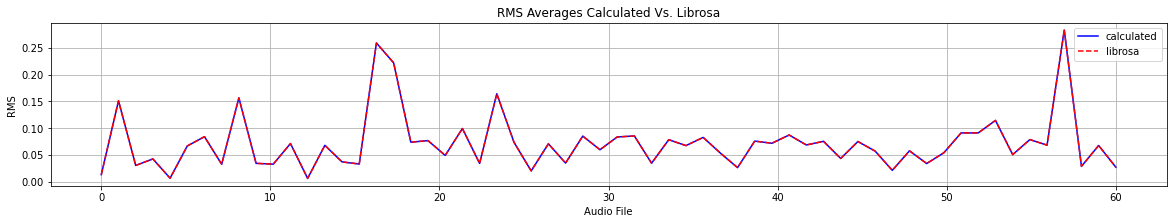

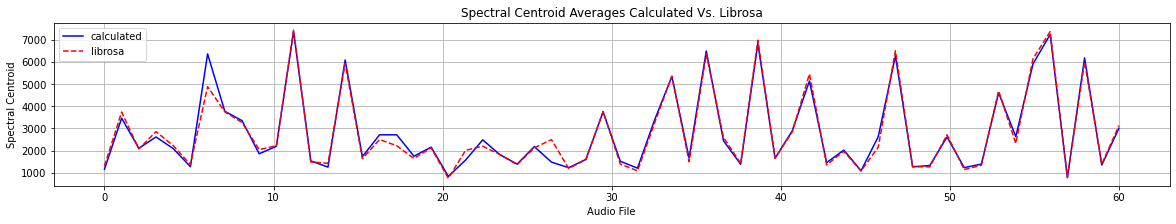

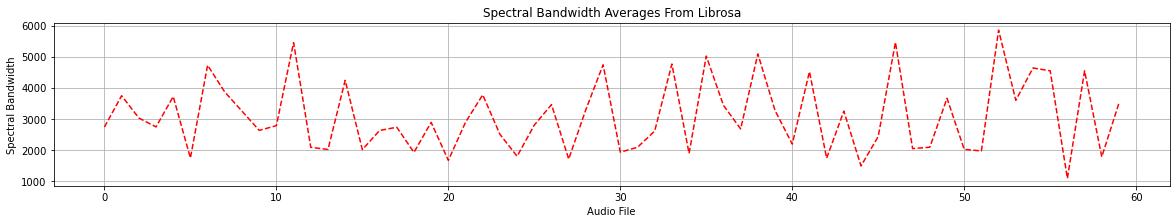

In [7]:
# Graph our calculated values vs. librosa's values
graph_calculation_vs_librosa(calculatedRmsArray, librosaRmsArray, "RMS")
graph_calculation_vs_librosa(calculatedSpectralCentroidArray, librosaSpectralCentroidArray, "Spectral Centroid")
graph_calculation_vs_librosa([], librosaSpectralBandwidthArray, "Spectral Bandwidth")

# 2. Display 3D Scatter Plot

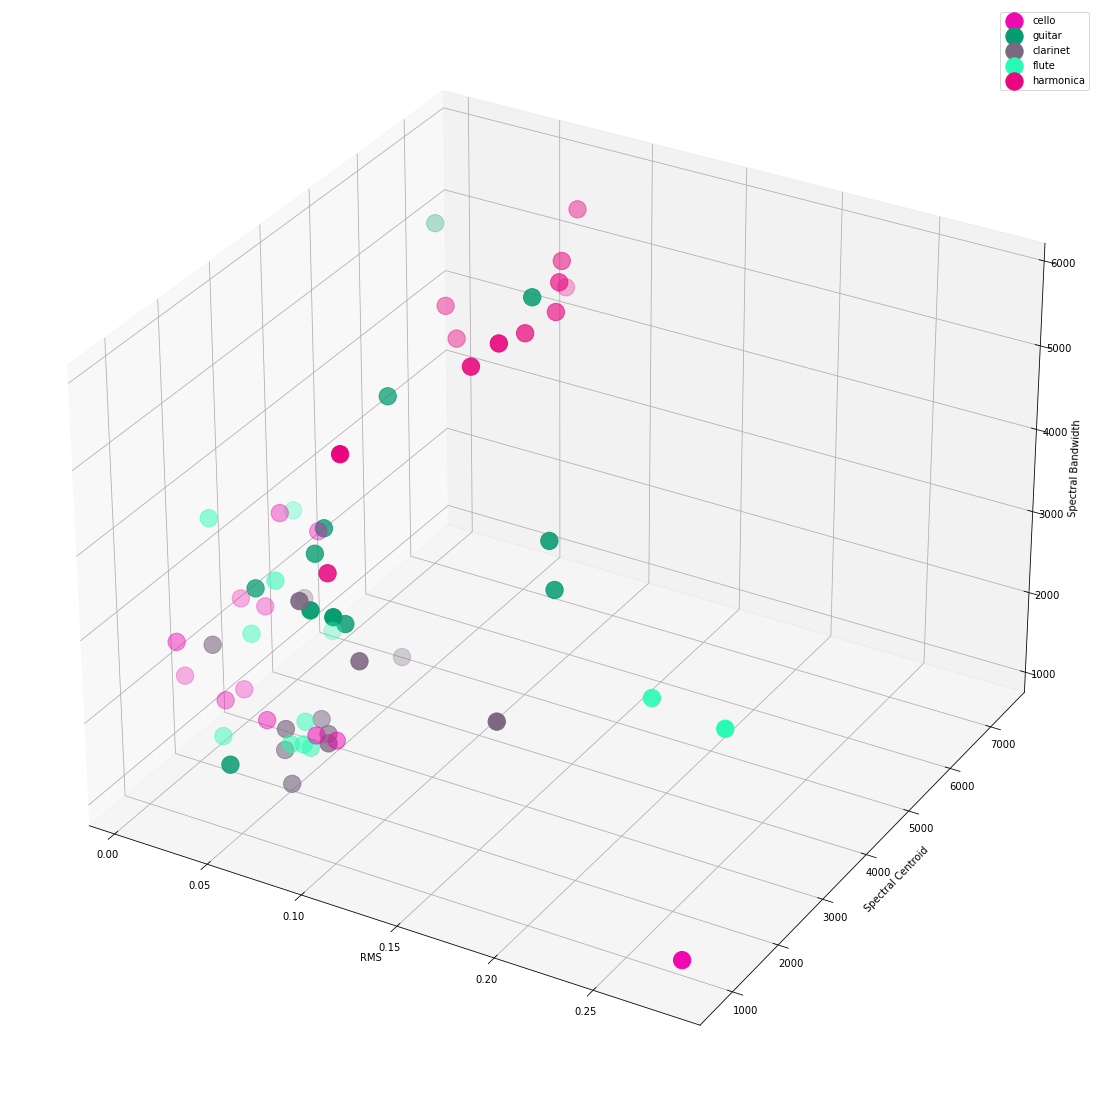

In [8]:
plt.figure(figsize=(20, 20))
ax = plt.axes(projection='3d')
for instrument in instrumentAverages:
    rms = instrumentAverages[instrument]['rms']
    sc = instrumentAverages[instrument]['sc']
    sb = instrumentAverages[instrument]['sb']
    red = random.random()
    green = random.random()
    blue = random.random()
    ax.scatter3D(rms, sc, sb, color=(red, green, blue), s=300)
    
plt.legend(instrumentTypes, loc='best')
ax.set_xlabel('RMS')
ax.set_ylabel('Spectral Centroid')
ax.set_zlabel('Spectral Bandwidth');

# 3. Apply Filters to Each File

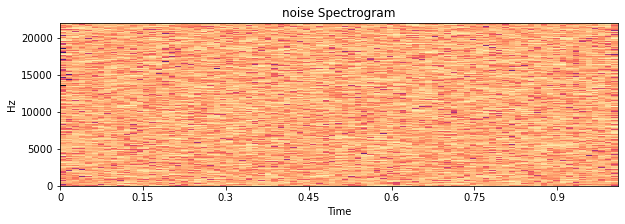

[ 5.10507512e-04 -7.43261355e-05 -5.93088805e-04 -1.79908151e-04
  6.28983922e-04  5.13567219e-04 -5.57886837e-04 -9.24044889e-04
  2.90378711e-04  1.34505524e-03  2.54695726e-04 -1.63615045e-03
 -1.10019508e-03  1.60159856e-03  2.16391479e-03 -1.04010351e-03
 -3.23316871e-03 -1.83107056e-04  3.97564335e-03  2.05915809e-03
 -3.99330954e-03 -4.37572140e-03  2.91486256e-03  6.69617115e-03
 -5.10569054e-04 -8.39243653e-03 -3.19518508e-03  8.73438642e-03
  7.84107345e-03 -7.02435073e-03 -1.26982757e-02  2.75233509e-03
  1.67018133e-02  4.26089294e-03 -1.85325869e-02 -1.37668374e-02
  1.67078426e-02  2.50654929e-02 -9.58036963e-03 -3.70678889e-02
 -5.01659197e-03  4.84400645e-02  3.14574760e-02 -5.78054872e-02
 -8.53314359e-02  6.39690256e-02  3.11057197e-01  4.33741777e-01
  3.11057197e-01  6.39690256e-02 -8.53314359e-02 -5.78054872e-02
  3.14574760e-02  4.84400645e-02 -5.01659197e-03 -3.70678889e-02
 -9.58036963e-03  2.50654929e-02  1.67078426e-02 -1.37668374e-02
 -1.85325869e-02  4.26089

/Users/jakobhoydal/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=64
  warnings.warn(


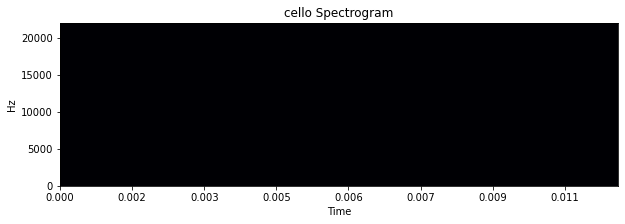

[ 5.16862034e-04 -7.49733729e-04 -4.53184681e-04  1.09850103e-03
  3.80961868e-04 -1.71791016e-03 -1.55732923e-04  2.63351523e-03
 -4.03293618e-04 -3.80911389e-03  1.49836876e-03  5.13560076e-03
 -3.33733008e-03 -6.42444657e-03  6.12122974e-03  7.40353343e-03
 -1.00421634e-02 -7.70892452e-03  1.53027213e-02  6.85718136e-03
 -2.21812750e-02 -4.15893853e-03  3.12080966e-02 -1.54463146e-03
 -4.36732009e-02  1.27767570e-02  6.34704206e-02 -3.74683039e-02
 -1.07715804e-01  1.25483141e-01  4.71657097e-01  4.71657097e-01
  1.25483141e-01 -1.07715804e-01 -3.74683039e-02  6.34704206e-02
  1.27767570e-02 -4.36732009e-02 -1.54463146e-03  3.12080966e-02
 -4.15893853e-03 -2.21812750e-02  6.85718136e-03  1.53027213e-02
 -7.70892452e-03 -1.00421634e-02  7.40353343e-03  6.12122974e-03
 -6.42444657e-03 -3.33733008e-03  5.13560076e-03  1.49836876e-03
 -3.80911389e-03 -4.03293618e-04  2.63351523e-03 -1.55732923e-04
 -1.71791016e-03  3.80961868e-04  1.09850103e-03 -4.53184681e-04
 -7.49733729e-04  5.16862

In [ ]:
instrumentFilters = {}

# Create filters for each instrument
for instrument in instrumentTypes:
    instrumentFilters[instrument] = InstrumentFilters()

# Apply filters to a 1 second noise array to display effects
noise = np.random.normal(0,1,44100)
graph_spectrogram(noise, "noise")

for instrument in instrumentFilters:
    filters = instrumentFilters[instrument]
    numtaps = filters.firTaps
    fc = filters.fc
    h = signal.firwin(numtaps, fc, pass_zero='lowpass')
    print(h)
    filtered = signal.lfilter(h, 1, noise)
    file = "./files/filtered/noise_" + instrument + "_filtered.wav"
    #PD IIR Filter Soe
    write(file, sr, filtered.astype(np.int16))

    iirFilter = filters.iirFilter
    #call puredata to overwrite filteredfiles
    #list all arguments
    filtertype = 'filtertype ' + str(iirFilter)
    fileName = ('fileName '+ file)
    #fileFiltered = ('newFileName '+ file)
    startFiltering = ('startFiltering 1')  
    PureDataIIR(filtertype, fileName, startFiltering)
    filtered, sr = librosa.load(file, sr=44100, mono=True)
    
    graph_spectrogram(filtered, instrument)

In [ ]:
# Create folder for filtered files if there isn't one already
filteredPath = "./files/filtered/"
if(os.path.isdir(filteredPath) == False):
    os.mkdir(filteredPath)
    
# Apply FIR filters to all audio files
for file in fileClasses:
    y = fileClasses[file].signal
    instrument = fileClasses[file].instrument
    filters = instrumentFilters[instrument]
    numtaps = filters.firTaps
    fc = filters.fc
    h = signal.firwin(numtaps, fc, pass_zero=True)
    h_padded = np.pad(h,[0,y.size-h.size])
    X = scipy.fft.fft(y)
    H = scipy.fft.fft(h_padded)
    Y = X*H
    # signal with FIR filter applied
    y = np.real(scipy.fft.ifft(Y))
    file = file.replace(".wav", "_filtered.wav")
    write(filteredPath + file, sr, y)
    
    #Apply IIR filters to all Audio Files
    iirFilter = filters.iirFilter
    #call puredata to overwrite filteredfiles
    filters = instrumentFilters(instrument)
    #list all arguments
    filtertype = (iirFilter + ' 1' )
    fileName = ('fileName '+ file)
    #fileFiltered = ('newFileName '+ file)
    startFiltering = ('startFiltering'+' 1')   
    PureDataIIR(self, filtertype, fileName, startFiltering)
    

#Overwrite all filtered files with IIR filter from pure data
for file in os.listdir("./files/filtered/"):

for instrument in instrumentFilters
    filters = intrumentFilters(instrument)
    fc = filters.fc
    
    
    
    graph_spectogram(filtered, instrument)

filt = 'lowpass'
file = 'test1.wav'


filtertype = (filt + ' 1' )
fileToFilter = ('OG_FileName '+file)
fileFiltered = ('newFileName '+('filtered_'+file))
startFiltering = ('startFiltering'+' 1')